In [1]:
!pip install netCDF4
!pip install keras-rectified-adam
!pip install kornia
import itertools

from scipy import linalg
import matplotlib.pyplot as plt 
import matplotlib as mpl



import netCDF4
from netCDF4 import Dataset
import pathlib


import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader

import xarray as xr

from datetime import date
import datetime
import kornia

     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 327kB 33.3MB/s 
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=6698b6c6386faa1d327a89465b84856d7b4268316438e786cf704b01b9f577a1
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam
     |████████████████████████████████| 163kB 2.8MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn import mixture
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


!pip install skorch
from skorch import NeuralNetClassifier
from sklearn.model_selection import cross_val_score

     |████████████████████████████████| 122kB 2.8MB/s 


# Load the dataset (2004 period)



In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
ds = xr.open_dataset("/content/gdrive/My Drive/dataset/SST_SSH_U_V_SLA_global_2004.nc")
print(ds.sizes)
ds

Frozen(SortedKeysDict({'lon': 1440, 'lat': 720, 'time': 366}))


<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 366)
Coordinates:
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time     (time) datetime64[ns] 2004-01-01T12:00:00 ... 1981-01-01
Data variables:
    SST      (time, lat, lon) float32 ...
    SSH      (time, lon, lat) float32 ...
    U        (time, lon, lat) float32 ...
    V        (time, lon, lat) float32 ...
    SLA      (time, lon, lat) float32 ...
Attributes:
    CDI:                    Climate Data Interface version 1.5.3 (http://code...
    Conventions:            CF-1.0
    history:                Mon Jul 21 17:26:58 2014: cdo merge SST_SSH_U_V_g...
    title:                  Analysed foundation sea surface temperature, global
    DSD_entry_id:           REMSS-L4LRfnd-GLOB-tmi_amsre_OI
    references:             none
    source_data:            TMI-REMSS,AMSRE-REMSS
    contact:                support@remss.com
    GDS_version_id:         GDS-v1.0-rev1.6
    netcdf_version_id:      3.5.0
    creation_date:          2010-08-04
    product_version:        v03
    spatial_resolution:     25 km
    start_date:             2003-12-30
    start_time:             00:00:00 UTC
    stop_date:              2004-01-03
    stop_time:              23:59:59 UTC
    southernmost_latitude:  -89.875
    northernmost_latitude:  89.875
    westernmost_longitude:  -179.875
    easternmost_longitude:  179.875
    file_quality_index:     1
    comment:                www.remss.com for more infomation on product
    CDO:                    Climate Data Operators version 1.5.3 (http://code...

<xarray.DataArray 'SSH' (time: 120, lat: 72, lon: 48)>
[414720 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 30.125 30.375 30.625 30.875 ... 41.375 41.625 41.875
  * lat      (lat) float32 -47.875 -47.625 -47.375 ... -30.625 -30.375 -30.125
  * time     (time) datetime64[ns] 2004-01-01T12:00:00 ... 2004-04-29T12:00:00
Attributes:
    long_name:        H
    units:            cm
    _CoordinateAxes:  time NbLongitudes NbLatitudes

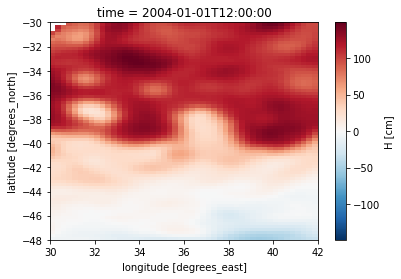

In [5]:
time_window = 120

ds_cut = ds.sel(lon=slice(30,42),lat=slice(-48,-30))
ds_cut = ds_cut.isel(time=slice(0,time_window))
SSH = ds_cut.SSH.transpose('time','lat','lon')
SSH[0].plot()
SSH

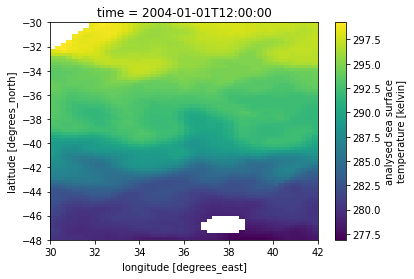

In [6]:
SST = ds_cut.SST
SST[0].plot()

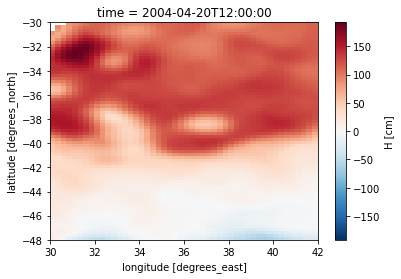

In [7]:
SSH[110].plot()

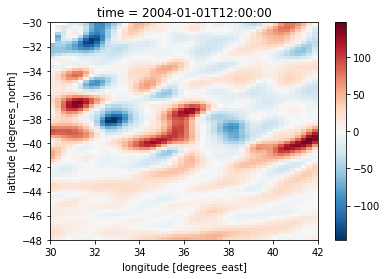

In [8]:
U = ds_cut.U.transpose('time','lat','lon')
V = ds_cut.V.transpose('time','lat','lon')
UV = U + V
UV[0].plot()

In [9]:
df = ds_cut.to_dataframe()
SST_x_max = df.SST.describe(include='all').loc['max']
SST_x_min = df.SST.describe(include='all').loc['min']
SSH_x_max = df.SSH.describe(include='all').loc['max']
SSH_x_min = df.SSH.describe(include='all').loc['min']
U_x_max = df.U.describe(include='all').loc['max']
U_x_min = df.U.describe(include='all').loc['min']
V_x_max = df.V.describe(include='all').loc['max']
V_x_min = df.V.describe(include='all').loc['min']
df.describe()

,SST,SSH,U,V,SLA
count,405000.000000,414120.000000,413640.000000,413640.000000,414720.000000
mean,290.646210,68.459991,6.150961,0.222889,6.277696
std,6.365062,54.519394,22.827393,25.368128,19.130518
min,276.750000,-62.506332,-107.527763,-156.930954,-83.590195
25%,284.399994,12.988934,-4.973430,-7.640310,-2.466063
50%,293.100006,83.187851,4.500406,0.802993,4.450123
75%,295.949982,118.468697,15.828811,9.747392,13.739470
max,302.100006,199.925827,121.118027,120.398727,89.636559


In [10]:
for v in ds_cut.data_vars:
    print('{:>10}: {}'.format(v, ds[v].attrs['long_name']))

       SST: analysed sea surface temperature
       SSH: H
         U: U
         V: V
       SLA: H


#Normalization

In [0]:
def pad_with(vector, pad_width, iaxis, kwargs):
  pad_value = kwargs.get('padder', 10)
  vector[:pad_width[0]] = pad_value
  vector[-pad_width[1]:] = pad_value

def normalize_negative_one(img):
    normalized_input = (img - np.amin(img)) / (np.amax(img) - np.amin(img))
    return 2*normalized_input - 1  

In [40]:
from sklearn.feature_extraction import image


#fill NaN values with the mean of the SSH, SST, U, V mean
SSTf = SST.fillna(SST.mean())
#SSTf = np.pad(SSTf, padding, pad_with, padder=SSTf.mean())
print('SST shape: {}'.format(SSTf.shape))


SSHf = SSH.fillna(SSH.mean())
print('SSH shape: {}'.format(SSHf.shape))

Uf = U.fillna(U.mean())
print('U shape: {}'.format(Uf.shape))

Vf = V.fillna(V.mean())
print('V shape: {}'.format(Vf.shape))

SST_n = np.empty(([time_window, 72,48]))
SSH_n = np.empty(([time_window, 72,48]))
U_n = np.empty(([time_window, 72,48]))
V_n = np.empty(([time_window, 72,48]))
#for each time step, compute patches of size (13x13), flatten them in 1D and concatenate them in SSH_patches, SST_patches, U_patches, V_patches
#output : 1D array of SSH patchs
for i in range(ds_cut.time.shape[0]):
  if (i%50 == 0):
    print("Round : "+ str(i))
  
  #print(SSH.shape[0])
  #for h in range(SSH[0].shape[0]):
  SSH_n[i] = (SSHf[i] - SSH_x_min)/(SSH_x_max-SSH_x_min)
  U_n[i] = (Uf[i] - U_x_min)/(U_x_max-U_x_min)
  V_n[i] = (Vf[i] - V_x_min)/(V_x_max-V_x_min)
  SST_n[i] = (SSTf[i] - SST_x_min)/(SST_x_max-SST_x_min)
  

  #print("SST " + str(SST[i].shape))




SST shape: (120, 72, 48)
SSH shape: (120, 72, 48)
U shape: (120, 72, 48)
V shape: (120, 72, 48)
Round : 0
Round : 50
Round : 100


In [0]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [0]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = torch.nn.Sequential(torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, dilation = 1, padding=1))
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, dilation = 1, padding=1),
            ReLU(inplace=True)
        )

        
    def forward(self, x):
      out1 = self.layer1(x)
      #out1 = self.cnn_layers(x)
      #out2 = self.fc1(out1)
      return out1    


(72, 48)
U : (120, 72, 48)
V : (120, 72, 48)
SSH : (120, 72, 48)
48
Y shape :(120, 72, 48, 3)
<class 'torch.Tensor'>
X_train : torch.Size([90, 3, 72, 48])
y_train : torch.Size([90, 3, 72, 48])
X_test : torch.Size([30, 3, 72, 48])
y_test : torch.Size([30, 3, 72, 48])
Epoch : 0
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([90, 3, 72, 48])
labels : torch.Size([90, 3, 72, 48])
[1,     1] loss: 0.607
laplacian : tensor(0.0189, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch : 1
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([90, 3, 72, 48])
labels : torch.Size([90, 3, 72, 48])
[2,     1] loss: 0.501
laplacian : tensor(0.0181, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch : 2
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([90, 3, 72, 48])
labels : torch.Size([90, 3, 72, 48])
[3,     1] loss: 0.313
laplacian : tensor(0.0171, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch : 3
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([90, 3, 72, 48

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[23,     1] loss: 0.245
laplacian : tensor(0.0237, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch : 23
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([90, 3, 72, 48])
labels : torch.Size([90, 3, 72, 48])
[24,     1] loss: 0.237
laplacian : tensor(0.0241, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch : 24
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([90, 3, 72, 48])
labels : torch.Size([90, 3, 72, 48])
[25,     1] loss: 0.230
laplacian : tensor(0.0246, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch : 25
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([90, 3, 72, 48])
labels : torch.Size([90, 3, 72, 48])
[26,     1] loss: 0.233
laplacian : tensor(0.0229, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch : 26
torch.DoubleTensor
torch.DoubleTensor
output : torch.Size([90, 3, 72, 48])
labels : torch.Size([90, 3, 72, 48])
[27,     1] loss: 0.234
laplacian : tensor(0.0230, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch : 27
torch.DoubleTenso

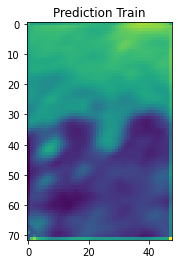

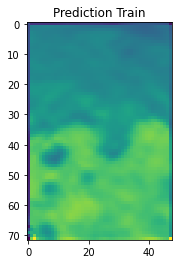

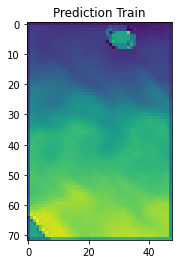

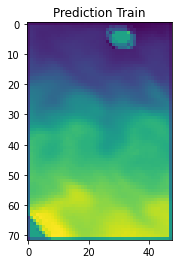

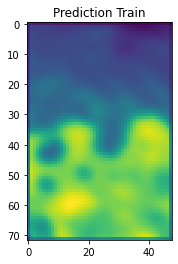

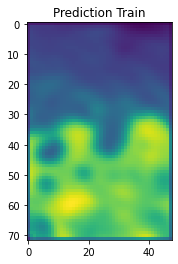

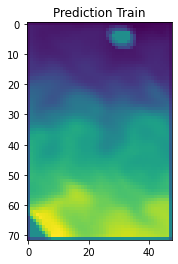

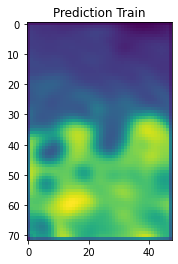

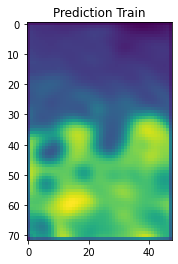

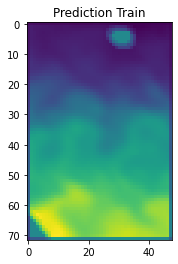

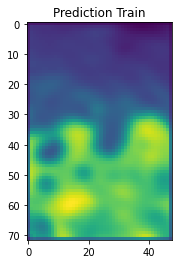

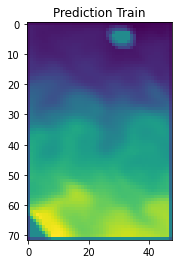

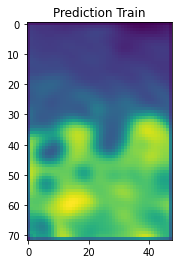

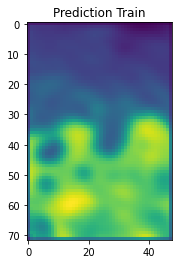

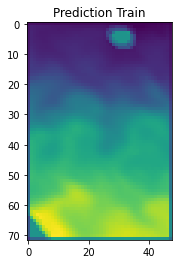

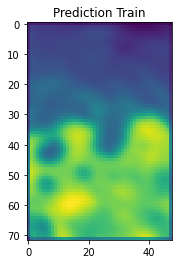

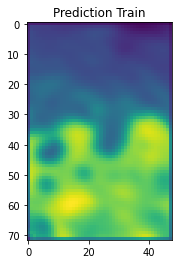

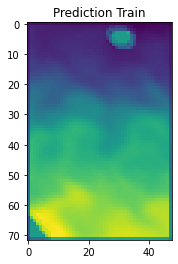

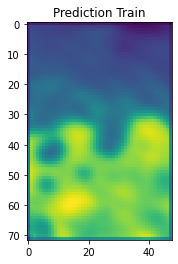

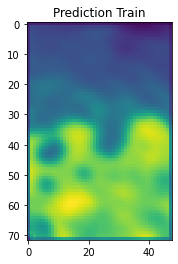

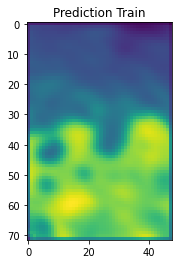

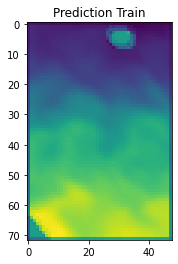

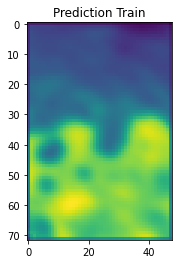

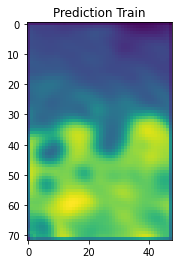

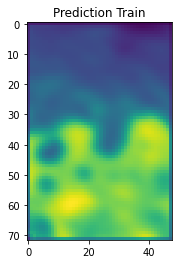

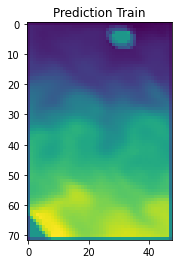

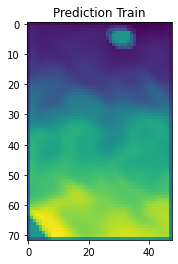

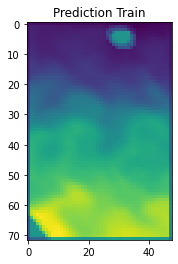

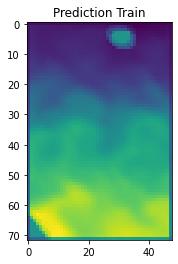

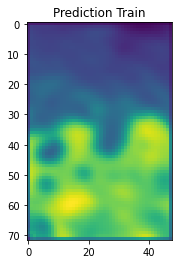

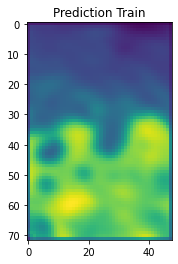

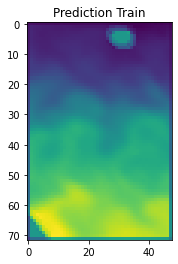

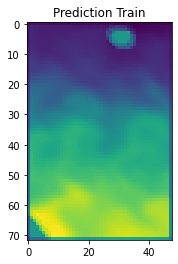

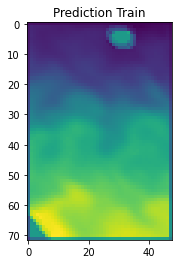

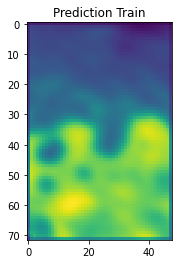

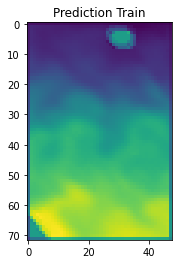

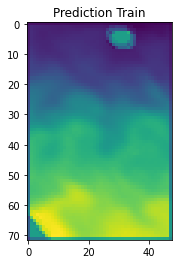

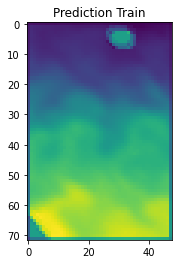

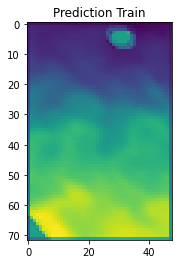

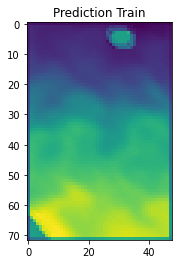

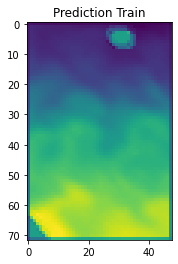

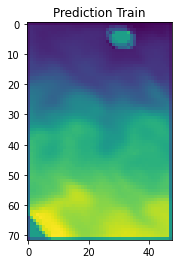

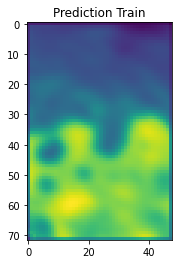

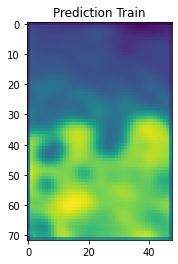

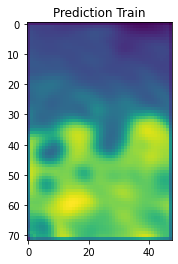

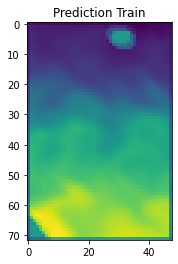

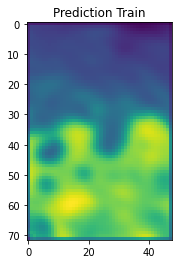

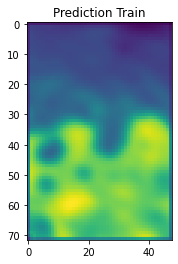

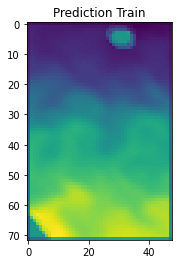

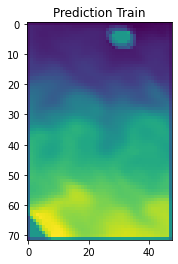

In [55]:
#X = np.stack((SST_patches,SSH, U, V))
X= SST_n
print(X[0].shape)

BATCH_SIZE = 90

print("U : " + str(U_n.shape))
print("V : " + str(V_n.shape))
print("SSH : " + str(SSH_n.shape))
y = np.stack((SSH_n, U_n, V_n)) 
y_nb_feature = y.shape[0]
#print magique
print(SST.shape[2])

y = y.reshape((time_window, SSH_n.shape[1], SSH_n.shape[2],y_nb_feature))
print("Y shape :" + str(y.shape))
# Split the data into training/testing sets
X_train_np = X[:90]
X_test_np = X[-30:]
#X_train_rsp = X_train_np.reshape((190, 1, 72, 48))

X_train_exp = np.expand_dims(X_train_np,1)
X_train_dup = torch.from_numpy(X_train_exp).double()
X_train = X_train_dup.repeat(1,3,1,1)

X_test_exp = np.expand_dims(X_test_np,1)
X_test_dup = torch.from_numpy(X_test_exp).double()
X_test = X_test_dup.repeat(1,3,1,1)

print(type(X_train))
# Split the targets into training/testing sets
y_train_np = y[:90]
y_test_np = y[-30:]

y_train_rp = y_train_np.reshape((90, 3, 72, 48))
y_test_rp = y_test_np.reshape((30, 3, 72, 48))

y_train = torch.from_numpy(y_train_rp).double()
y_test = torch.from_numpy(y_test_rp).double()

#train = torch.utils.data.TensorDataset(X_train,y_train)

train_loader = DataLoader([X_train,y_train], batch_size=90, shuffle=True)
test_loader = DataLoader([X_test,y_test], batch_size=30, shuffle=False)

print("X_train : " + str(X_train.shape))
print("y_train : " + str(y_train.shape))
print("X_test : " + str(X_test.shape))
print("y_test : " + str(y_test.shape))


# Hyperparameters
num_epochs = 50
batch_size = 90
learning_rate = 0.01


#torch.manual_seed(RANDOM_SEED)

model = ConvNet()
model = model.double()

#model = ConvNet()
#model = model.double()
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
loss_list = []
acc_list = []
lap_list = []
for epoch in range(num_epochs):
  running_loss = 0.0
  running_lap = 0.0
  print("Epoch : " + str(epoch))
  for i, (images, labels) in enumerate(train_loader):
    # Run the forward pass
    print(images.type())
    print(labels.type())
    outputs = model(images)
    print("output : " + str(outputs.shape))
    print("labels : " + str(labels.shape))
    loss = torch.sqrt(criterion(outputs, labels))

    lap_out = kornia.filters.laplacian(outputs,3)
    lap_lab = kornia.filters.laplacian(labels,3)
    lap = torch.sqrt(criterion(lap_out, lap_lab))

    loss_list.append(loss.item())
    lap_list.append(lap)

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_lap += lap
    if i % 90 == 0: 
      print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss ))
      print('laplacian : ' + str(running_lap))
      plt.figure()
      plt.title('Prediction Train')
      plt.imshow(torch.exp(outputs[0,2,:,:]).detach().cpu(), label='OUTPUT')
      running_loss = 0.0






tensor([[0.1239, 0.1410, 0.1382,  ..., 0.0972, 0.1018, 0.0788],
        [0.1616, 0.2110, 0.2013,  ..., 0.1218, 0.1294, 0.1097],
        [0.1642, 0.2148, 0.2022,  ..., 0.1297, 0.1404, 0.1176],
        ...,
        [0.4120, 0.6247, 0.6247,  ..., 0.8628, 0.8650, 0.6139],
        [0.4120, 0.6247, 0.6247,  ..., 0.8651, 0.8669, 0.6130],
        [0.3037, 0.4692, 0.4692,  ..., 0.6440, 0.6450, 0.5275]],
       dtype=torch.float64, grad_fn=<SliceBackward>)


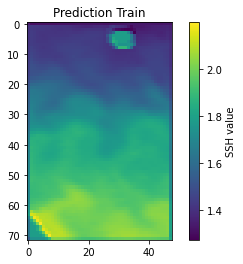

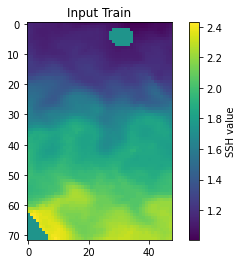

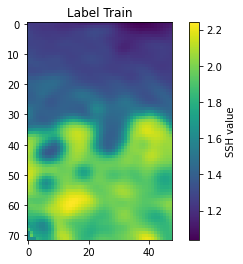

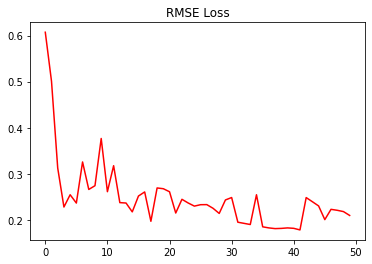

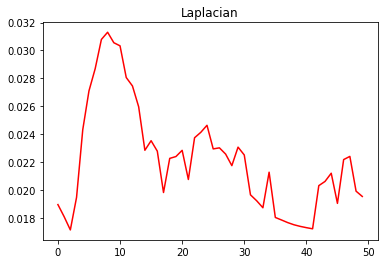

In [56]:
print(outputs[0,2,:,:])
plt.figure()
plt.title('Prediction Train')
plt.imshow(torch.exp(outputs[0,0,:,:]).detach().cpu(), label='OUTPUT')
#plt.clim(-3, 3)
plt.colorbar(label = 'SSH value')
plt.figure()
plt.title('Input Train')
plt.imshow(torch.exp(images[0,0,:,:]).detach().cpu(), label='OUTPUT')
#plt.clim(-3, 3)
plt.colorbar(label = 'SSH value')
plt.figure()
plt.title('Label Train')
plt.imshow(torch.exp(y_train[0,0,:,:]).detach().cpu(), label='LABEL') 
#plt.clim(-3, 3)
plt.colorbar(label = 'SSH value')
plt.figure()
plt.title('RMSE Loss')
plt.plot(np.array(loss_list), 'r')

plt.figure()
plt.title('Laplacian')
plt.plot(np.array(lap_list), 'r')


In [57]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for im, lab in test_loader:
        outputs_test = model(im)
        print("outputs_test : " + str(outputs_test.shape))
        _, predicted = torch.max(outputs_test, 1)
        print("predicted : " + str(predicted.shape))
        print("labels : " + str(lab.shape))
        total += lab.size(0)
        print("total : " + str(total))
        correct += (outputs_test == lab).sum().item()
        print("correct : " + str(correct))

    print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))



outputs_test : torch.Size([30, 3, 72, 48])
predicted : torch.Size([30, 72, 48])
labels : torch.Size([30, 3, 72, 48])
total : 30
correct : 0
Test Accuracy of the model on the test images: 0.0 %


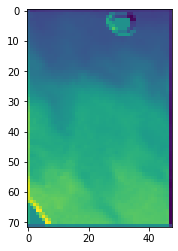

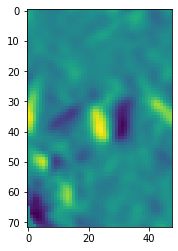

In [29]:
plt.figure()
plt.imshow(torch.exp(outputs_test[10,0,:,:]).detach().cpu())
plt.figure()
plt.imshow(torch.exp(lab[0,0,:,:]).detach().cpu())  # plot class1

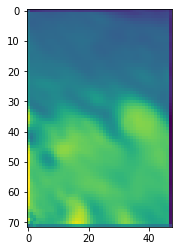

In [30]:
plt.figure()
plt.imshow(torch.exp(outputs[20,0,:,:]).detach().cpu(), label='OUTPUT')

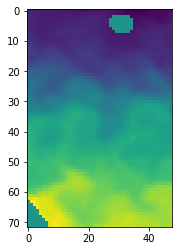

In [46]:
plt.figure()
plt.imshow(torch.exp(images[0,0,:,:]).detach().cpu(), label='LABEL') 

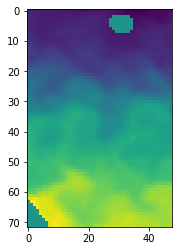

In [53]:
plt.figure()
plt.imshow(torch.exp(X_train[0,0,:,:]).detach().cpu(), label='LABEL') 

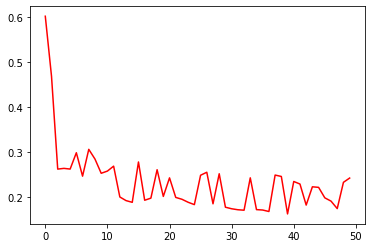

In [32]:
plt.plot(np.array(loss_list), 'r')

[[0.21693842 0.21472597 0.21338467 ... 0.09762648 0.10520961 0.1108307 ]
 [0.23600033 0.22473978 0.2170475  ... 0.10763428 0.11932342 0.12951872]
 [0.25110143 0.2340114  0.22354679 ... 0.12446788 0.13773222 0.14990127]
 ...
 [0.49904889 0.62908685 0.55243802 ... 0.61563939 0.61169457 0.61985147]
 [0.49904889 0.67119944 0.57574224 ... 0.62275892 0.61220044 0.61576819]
 [0.49904889 0.49904889 0.49904889 ... 0.63112634 0.61427557 0.61374074]]


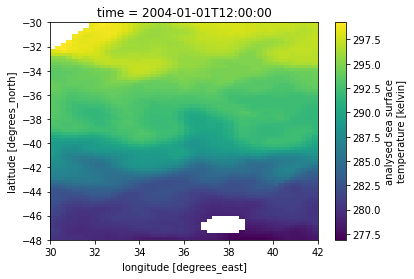

In [38]:
SST[0].plot()
print(SSH_n[0])

In [0]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)